
# Evaluating a Hugging Face RAG Pipeline (Retrieve → Rerank) with ChromaDB
<img src="https://raw.githubusercontent.com/CNUClasses/CPSC471/master/content/lectures/week13/evaluate_rag_system_no_heading.png" alt="standard" style="max-height:400px;  margin:10px 0; vertical-align:middle;">


**Goal:** Evaluate a RAG pipeline that **retrieves** from ChromaDB and **reranks** with a cross-encoder (no generation).  
We use the provided:
- **API module:** `rag_pipeline_api.py` (week13)  
- **Evaluation data:** `rag_eval_dataset.csv` (week13) — questions were generated from a random 10% sample of chunks in the same Chroma collection, so the relevant chunk **is** in Chroma.

**Metrics you will compute:**
- **Precision@5 / Precision@10** — How clean are the top results?
- **Recall@5 / Recall@10** — Do we miss the relevant chunk?
- **MAP (Mean Average Precision)** — Smooth ranking-quality measure across queries.
- **MRR (Mean Reciprocal Rank)** — How early do we see the **first** relevant chunk?

> <mark>We assume **one relevant chunk per question** (the original `chunk_id` in the CSV). If it doesn't appear among the top-K results, Precision/Recall@K are 0 for that K, AP=0, RR=0.



## 0) Setup & Configuration

- If needed, install dependencies (ChromaDB + SentenceTransformers + tqdm + matplotlib).
- Set your **ChromaDB persist directory** and **collection name** so we can open the same DB that produced the evaluation CSV.
- We will download the `rag_pipeline_api.py` and the `rag_eval_dataset.csv` from the course GitHub repo if not found locally.


In [ ]:

# If you need to install dependencies, uncomment and run:
# !pip install -U chromadb sentence-transformers torch pandas numpy tqdm matplotlib requests

import os
import sys
import json
import math
from pathlib import Path

# ---------- Configuration (EDIT THESE) ----------
# Location of your Chroma persistent store and the collection name you used.
PERSIST_DIR = "../week12/rag_chroma"        # ChromaDB persistence path (folder will be created)
# PERSIST_DIR = os.getenv("../week12", "./rag_chroma")
COLLECTION_NAME= "cnu_rag_lab"                       # collection name used previously

# Optionally limit the number of evaluation questions (for quick runs).
EVAL_LIMIT = -1  # set -1 for all

# Remote resources (week13)
RAG_API_URL   = "https://raw.githubusercontent.com/CNUClasses/471_code/master/week13/rag_pipeline_api.py"
EVAL_CSV_URL  = "https://raw.githubusercontent.com/CNUClasses/471_code/master/week13/rag_eval_dataset.csv"

# Local fallback paths
RAG_API_LOCAL = Path("rag_pipeline_api.py")
EVAL_CSV_LOCAL = Path("rag_eval_dataset.csv")



## 1) Fetch the API helper and load the evaluation CSV

- We will use `rag_pipeline_api.py` from **week13** (the same API used to build/serve your pipeline).  
- The evaluation CSV contains (`chunk_id`, `question`, `answer`, `metadata`, …). We only need `question` and the ground-truth `chunk_id`.


In [2]:

import requests
import pandas as pd

def ensure_file(local_path: Path, url: str):
    if not local_path.exists():
        print(f"Downloading {url} → {local_path} ...")
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        local_path.write_bytes(r.content)
    else:
        print(f"Found local file: {local_path}")

# Ensure the API module is available
ensure_file(RAG_API_LOCAL, RAG_API_URL)

# Import the helper (adds the directory to sys.path if needed)
if str(Path(".").resolve()) not in sys.path:
    sys.path.append(str(Path(".").resolve()))

from rag_pipeline_api import load_chroma, query_reranked  # provided by week13

# Ensure the evaluation CSV is available
ensure_file(EVAL_CSV_LOCAL, EVAL_CSV_URL)

# Load evaluation data
eval_df = pd.read_csv(EVAL_CSV_LOCAL)
# Minimal columns expected: chunk_id, question (answers present but not used for retrieval metrics)
eval_df = eval_df[['chunk_id', 'question']].rename(columns={'chunk_id': 'relevant_chunk_id'})
print(f"Loaded {len(eval_df)} evaluation rows.")
eval_df.head(3)


Found local file: rag_pipeline_api.py
Found local file: rag_eval_dataset.csv
Loaded 607 evaluation rows.


,relevant_chunk_id,question
0,7,What days of the week are campus tours offered...
1,7,How can one schedule a visit to Christopher Ne...
2,7,What is the phone number to call for schedulin...



## 2) Open Chroma and warm up models

We open the **exact same** Chroma collection used when generating the dataset and load:
- **Bi-encoder** (SentenceTransformers) for query embeddings (dense retrieval).
- **Cross-encoder** for reranking top-N candidates.


In [16]:

# Load the collection + models (device can be "cpu", "cuda", or "mps")
handle = load_chroma(
    persist_dir=PERSIST_DIR,
    collection_name=COLLECTION_NAME,
    
    embedding_model="sentence-transformers/msmarco-distilbert-cos-v5",     # match ingestion embedder
    reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",        # compact reranker
    device="cuda"                                                   # set "cuda" if you have a GPU
)
print("Chroma + models are ready. Embedding dim:", handle.embed_dim)


Chroma + models are ready. Embedding dim: 768



## 3) Metric helpers

We assume **one relevant chunk** per query: the `relevant_chunk_id`.  
- **Precision@K**: fraction of the top-K results that are relevant (0 or 1/K here).  
- **Recall@K**: fraction of relevant items retrieved in top-K (0 or 1 here).  
- **AP**: mean of precisions at the ranks where relevant items appear (here, either 0 or 1/rank).  
- **RR**: 1 divided by the rank of the first relevant item (or 0 if not found).


In [7]:

from typing import List, Set, Dict, Any
import numpy as np

def precision_at_k(ranked: List[str], relevant: Set[str], k: int) -> float:
    top_k = ranked[:k]
    hits = sum(1 for d in top_k if d in relevant)
    return hits / float(k)

def recall_at_k(ranked: List[str], relevant: Set[str], k: int) -> float:
    if not relevant:
        return 0.0
    top_k = ranked[:k]
    hits = sum(1 for d in top_k if d in relevant)
    return hits / float(len(relevant))

def average_precision(ranked: List[str], relevant: Set[str]) -> float:
    if not relevant:
        return 0.0
    hits = 0
    precisions = []
    for i, doc_id in enumerate(ranked, start=1):
        if doc_id in relevant:
            hits += 1
            precisions.append(hits / i)
    return float(np.mean(precisions)) if precisions else 0.0

def reciprocal_rank(ranked: List[str], relevant: Set[str]) -> float:
    for i, doc_id in enumerate(ranked, start=1):
        if doc_id in relevant:
            return 1.0 / i
    return 0.0

def evaluate_one_query(ranked_ids: List[str], relevant_id: str) -> Dict[str, Any]:
    rel = {str(relevant_id)}
    metrics = {
        "P@5":  precision_at_k(ranked_ids, rel, 5),
        "P@10": precision_at_k(ranked_ids, rel, 10),
        "R@5":  recall_at_k(ranked_ids, rel, 5),
        "R@10": recall_at_k(ranked_ids, rel, 10),
        "AP":   average_precision(ranked_ids, rel),
        "RR":   reciprocal_rank(ranked_ids, rel),
    }
    # Report the (1-indexed) rank where the relevant id appears (np.inf if missing)
    try:
        pos = ranked_ids.index(str(relevant_id))
        metrics["rank_of_relevant"] = pos + 1
    except ValueError:
        metrics["rank_of_relevant"] = float("inf")
    return metrics



## 4) Evaluate the pipeline over the dataset

For each **question**:
1. Use `query_reranked(...)` to get **top-K reranked** chunk IDs from Chroma.  
2. Compare with the ground-truth `relevant_chunk_id`.  
3. Compute metrics **P@5, P@10, R@5, R@10, AP, RR**.  
4. Aggregate across questions to report **MAP** and **MRR**.

> For runtime, you can cap the number of evaluation rows by setting `EVAL_LIMIT` in the config.


In [31]:

from tqdm import tqdm
import pandas as pd


# How many candidates to retrieve before reranking, and how many to keep.
TOP_K_CANDIDATES = int(os.getenv("TOP_K_CANDIDATES", "100"))    #the more you get the better your metrics
TOP_K_RETURN     = int(os.getenv("TOP_K_RETURN", "10"))

subset = eval_df if EVAL_LIMIT < 0 else eval_df.head(EVAL_LIMIT).copy()

records = []
for _, row in tqdm(subset.iterrows(), total=len(subset), desc="Evaluating"):
    q = str(row["question"])
    relevant_id = str(row["relevant_chunk_id"])

    # Retrieve→Rerank (top-K candidates, keep top-K return)
    results = query_reranked(
        handle,
        query=q,
        top_k_candidates=TOP_K_CANDIDATES,
        top_k_return=TOP_K_RETURN
    )

    ranked_ids = [str(r["id"]) for r in results]  # ensure string type for comparison
    m = evaluate_one_query(ranked_ids, relevant_id)
    records.append({"question": q, "relevant_id": relevant_id, **m})

results_df = pd.DataFrame(records)
print("Preview of per-query metrics:")
results_df.head(5)


Evaluating: 100%|██████████| 607/607 [01:04<00:00,  9.38it/s]

Preview of per-query metrics:


,question,relevant_id,P@5,P@10,R@5,R@10,AP,RR,rank_of_relevant
0,What days of the week are campus tours offered...,7,0.2,0.1,1.0,1.0,1.0,1.0,1.0
1,How can one schedule a visit to Christopher Ne...,7,0.2,0.1,1.0,1.0,1.0,1.0,1.0
2,What is the phone number to call for schedulin...,7,0.2,0.1,1.0,1.0,1.0,1.0,1.0
3,Is it possible to schedule a campus tour on ma...,7,0.2,0.1,1.0,1.0,1.0,1.0,1.0
4,What is the website address to schedule a visi...,7,0.2,0.1,1.0,1.0,1.0,1.0,1.0



## 5) Aggregate scores (MAP, MRR, and mean P/R@K)


In [18]:

MAP = results_df["AP"].mean()
MRR = results_df["RR"].mean()

summary = pd.DataFrame({
    "Metric": ["MAP", "MRR", "Precision@5 (mean)", "Precision@10 (mean)", "Recall@5 (mean)", "Recall@10 (mean)"],
    "Score":  [MAP, MRR, results_df["P@5"].mean(), results_df["P@10"].mean(), results_df["R@5"].mean(), results_df["R@10"].mean()]
})
summary


,Metric,Score
0,MAP,0.753907
1,MRR,0.753907
2,Precision@5 (mean),0.169687
3,Precision@10 (mean),0.087315
4,Recall@5 (mean),0.848435
5,Recall@10 (mean),0.873147



## 6) Diagnostic: rank of the relevant chunk


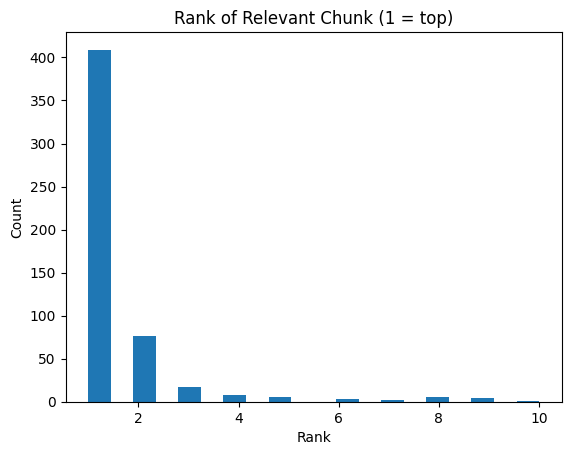

In [19]:

import matplotlib.pyplot as plt
import numpy as np

ranks = results_df["rank_of_relevant"].replace(np.inf, np.nan).dropna()

plt.figure()
plt.hist(ranks, bins=20)
plt.title("Rank of Relevant Chunk (1 = top)")
plt.xlabel("Rank")
plt.ylabel("Count")
plt.show()



## 7) (Optional) Save detailed per-query results


In [ ]:

OUT_CSV = "rag_eval_per_query_metrics.csv"
results_df.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV}")



## 8) Notes & Extensions

- **Dense-only vs Reranked:** To compare, you can modify `rag_pipeline_api.py` to return **dense order** as well and compute metrics for both.  
- **K sensitivity:** Try different `TOP_K_CANDIDATES` and `TOP_K_RETURN` to see how MRR/MAP shift (e.g., 20/10, 100/20).  
- **Hybrid retrieval:** Add a BM25+dense **hybrid** stage then rerank to test if it improves early precision.  
- **Speed:** Use `device="cuda"` (or `"mps"`) for faster cross-encoder reranking.  
- **Multiple relevants:** If your chunks overlap, consider labeling multiple relevant chunk IDs per question and adapt the metric functions to multi-relevant sets.
